# Face Detection - Model Evaluation

**Author: Brian van den Berg**

This notebook tests and evaluates the performance of face detection models. The performance is measured by finding the amount of True Positives (TP), False Positives (FP) and False Negatives (FN). During execution, it is possible to view the evaluated images as long as the flag is raised and a UI is available to display opencv Matrices on. The reason for this research was out of personal interest and to support an assignment for a university class called 'Human Machine Interfaces'. Originally we only had to train a Haar Cascade classifier, but I wanted to benchmark our own model against the pre-made one and against another very popular relatively new classifier 'yunet'.

In [343]:
import os
import sys
import math
import time
import matplotlib.pyplot as plt
import cv2

## Setup

To spare you the details, in the setup, the face annotations made with the opencv_annotation tool are loaded into a list of dictionaries containing the outlines of boxes. Besides that, the functions are created to perform an evaluation and if you are interested in how I solved the issue of matching annotations with detections to get the metrics for evaluation, then I would recommend you to read the following code cells.

### Fetch Annotations

Change the path to the correct path, or an absolute one to the annotations file created using the 'opencv_annotation' tool.

In [344]:
annotations_path = os.path.join('test', 'info.dat')

# Initialize an empty list to store annotations
annotations = []
num_pictures = 0

# Open the annotations file for reading
with open(annotations_path, 'r') as file:
    # Loop through the lines in the annotation file
    for i, line in enumerate(file):
        # Increment the line count
        num_pictures = i + 1

        # Split the line into values
        values = line.strip().split()

        # Check for the end of the annotations file
        if len(values) == 0:
            break

        # Get the image path and number of faces in the image
        img_path = values[0]
        face_index = 1

        # Error check the line to ensure it has the expected format
        try:
            num_faces = int(values[face_index])
        except ValueError:
            print(f'Line {i}: Warning: Skipping Line; Incorrect Format:')
            print(f'- Line: "{line.strip()}"')
            continue

        # Loop through every face in the picture
        for _ in range(num_faces):
            # Get the variables for face 'j' in the picture
            face_x = int(values[face_index + 1])
            face_y = int(values[face_index + 2])
            face_w = int(values[face_index + 3])
            face_h = int(values[face_index + 4])
            
            # Increment the face_index for the next face
            face_index += 4

            # Save the variables as a facebox
            annotation = {
                'filename': img_path,
                'x': face_x,
                'y': face_y,
                'w': face_w,
                'h': face_h
            }
            # Append the facebox to the list
            annotations.append(annotation)

# Print the result for debugging
print(f'Info: '
      f'Found {len(annotations)} face{"s" if len(annotations) > 1 else ""} '
      f'in {num_pictures} picture{"s" if num_pictures > 1 else ""}')

Info: Found 47 faces in 2 pictures


### Setup Model Evaluation

As an addition to the already commented on structure, I'll also add that the 'detect_callback' arguement in 'evaluate_model' is a function callback that is called to perform face detection on an image. It is expected that the function passes a cv2.Mat type BGR image to get a list of dictionaries containing the detected faces much like the annotations, but without 'filename' defined.

In [345]:
def calculate_center(box: dict[str, int]) -> tuple[int, int]:
    """Calculate the center of a bounding box."""
    x = round(box['x'] + box['w'] / 2)
    y = round(box['y'] + box['h'] / 2)
    return x, y

def calculate_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    """Calculate the Euclidean distance between two points."""
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def find_matching_annotation(annotations: list[dict[str, int]], detected: dict[str, int], error_threshold: float=0.25) -> tuple[bool, list[dict[str, any]]]:
    """Find and match the closest annotation to a detected face."""
    detected_center = calculate_center(detected)

    # Find the closest label
    minimum_distance = sys.float_info.max
    minimum_index = None
    for i, annotation in enumerate(annotations):
        annotation_center = calculate_center(annotation)
        distance = calculate_distance(detected_center, annotation_center)
        if distance < minimum_distance:
            minimum_distance = distance
            minimum_index = i

    # If there were no labels, return False
    if minimum_index is None:
        return False, annotations
    
    # Calculate the distance requirement based on the size of the annotation
    annotation = annotations[minimum_index]
    allowed_distance = (annotation['h'] / 2) * error_threshold if annotation['h'] > annotation['w'] else (annotation['w'] / 2) * error_threshold

    # Check if the distance abides
    if minimum_distance < allowed_distance:
        # If distance is within the limit, remove the matched label
        del annotations[minimum_index]
        return True, annotations
    else:
        # If distance is too large, keep the label
        return False, annotations

def draw_rectangle(image: cv2.Mat, box: cv2.Mat, color: tuple[int, int, int]=(0, 255, 0), thickness: int=1) -> None:
    """Draw a rectangle on the image."""
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    cv2.rectangle(image, (x, y), (x+w, y+h), color, thickness)

def evaluate_model(detect_callback, labels: list[dict[str, any]], detection_threshold: int=0.25) -> dict[str, dict[str, any]]:
    """Evaluate a face detection model."""
    results = {}

    # Iterate through every label
    for label in labels:
        img_path = label['filename']
        if img_path in results:
            continue

        # Setup the evaluation metrics
        TP, FP, FN = 0, 0, 0

        # Get every annotation associated with the image
        annotations = [annotation for annotation in labels if annotation.get('filename') == img_path]

        # Detect faces in the test image using the provided callback
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        detected, realtime_factor = detect_callback(img)

        # Match every detected face with the annotations
        image_size = len(img) if len(img) > len(img[0]) else len(img[0])
        thickness = math.ceil(image_size / 1250)
        for box in detected:
            ret, annotations = find_matching_annotation(annotations, box, detection_threshold)
            if ret:
                # Detected face matches annotation (True Positive)
                draw_rectangle(img, box, (0, 255, 0), thickness)
                TP += 1
            else:
                # Detected face does not match annotation (False Positive)
                draw_rectangle(img, box, (0, 255, 255), thickness)
                FP += 1

        # Remaining annotations were not detected (False Negative)
        FN = len(annotations)
        for annotation in annotations:
            draw_rectangle(img, annotation, (0, 0, 255), thickness)
        
        # Add the metrics to the result
        results[img_path] = {'image': img, 'RTF': realtime_factor, 'TP': TP, 'FP': FP, 'FN': FN}

    return results

def get_image_paths(evaluation_results: dict[str, dict[str, any]]) -> list[str]:
    """Gets filenames from evaluation results"""
    return list(evaluation_results.keys())

## Evaluation

### Metrics Calculations

In [346]:
def calc_precision(TP: int, FP: int) -> float:
    """Calculate precision (TP / (TP + FP))."""
    try:
        return TP / (TP + FP)
    except ZeroDivisionError:
        return 0.0

def calc_recall(TP: int, FN: int) -> float:
    """Calculate recall (TP / (TP + FN))."""
    try:
        return TP / (TP + FN)
    except ZeroDivisionError:
        return 0.0

def calc_f1_score(precision: float, recall: float) -> float:
    """Calculate F1-score (2 * (precision * recall) / (precision + recall))."""
    try: 
        return 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        return 0.0

def calc_evaluation_metrics(image_info: dict[str, any]) -> dict[str, any]:
    """Calculate evaluation scores (precision, recall, and F1-score)."""
    # Get the evaluations
    TP, FP, FN = image_info['TP'], image_info['FP'], image_info['FN']
    
    # Calculate the evaluation scores
    precision, recall = calc_precision(TP, FP), calc_recall(TP, FN)
    f1_score = calc_f1_score(precision, recall)

    # Store the evaluation scores back into the array
    image_info['precision'], image_info['recall'], image_info['f1-score'] = precision, recall, f1_score

    return image_info

def print_summary(model_name: str, evaluation_results: dict[str, dict[str, any]]) -> None:
    """Print a summary of evaluation results for a given model."""
    # Get the total number of evaluations
    TP, FP, FN, realtime_factor, height, width = 0, 0, 0, 0, 0, 0
    image_paths = get_image_paths(evaluation_results)

    for path in image_paths:
        TP += evaluation_results[path]['TP']
        FP += evaluation_results[path]['FP']
        FN += evaluation_results[path]['FN']
        realtime_factor += evaluation_results[path]['RTF']
        height += len(evaluation_results[path]['image'])
        width += len(evaluation_results[path]['image'][0])
    
    # Calculate the overall precision, recall, and F1-score
    precision, recall = calc_precision(TP, FP), calc_recall(TP, FN)
    f1_score = calc_f1_score(precision, recall)

    # Take the averages
    realtime_factor /= len(image_paths)
    height /= len(image_paths)
    width /= len(image_paths)

    # Print the summary in the terminal
    print("=========================================")
    print(f'Model: {model_name}')
    print(f'- precision: {precision * 100:.2f}%')
    print(f'- recall: {recall * 100:.2f}%')
    print(f'- f1-score: {f1_score * 100:.2f}%')
    print(f'- RTF: {realtime_factor * 1000:.2f}ms')
    print(f'- average pixel-count: {(round(height * width))}')
    print(f'- average image-shape: {(round(height), round(width))}')
    print("=========================================")

### Yunet

In [347]:
# Setup a dictionary to collect all of the reults in
evaluations_collection = {}

# Initialize the yunet model
yunet_model_path = os.path.join('models', 'yunet.onnx')
yunet = cv2.FaceDetectorYN.create(
    model=      yunet_model_path,
    config=     "",
    input_size= (0, 0)
)

# Define a detect callback function that delivers the result in the required format
def yunet_detect(img: cv2.Mat) -> list[dict[str, int]]:
    start_time = time.time()
    yunet.setInputSize((img.shape[1], img.shape[0]))
    _, faces = yunet.detect(img)
    realtime_factor = time.time() - start_time

    # Append the results together
    result = []
    for face in faces:
        result.append({
            'x': int(face[0]),
            'y': int(face[1]),
            'w': int(face[2]),
            'h': int(face[3])
        })
    return result, realtime_factor

# Print the title
print('YuNet Model Evaluations:')

# Perform the evaluation on yunet
evaluation_results = evaluate_model(yunet_detect, annotations, detection_threshold=0.3)

# Calculate additional evaluation metrics
image_paths = get_image_paths(evaluation_results)
for path in image_paths:
    calc_evaluation_metrics(evaluation_results[path])

# Print the test score summary
print_summary('yunet.onnx', evaluation_results)

# Store the results
evaluations_collection['yunet.onnx'] = evaluation_results

YuNet Model Evaluations:


Model: yunet.onnx
- precision: 100.00%
- recall: 89.36%
- f1-score: 94.38%
- RTF: 129.42ms
- average pixel-count: 1379531
- average image-shape: (938, 1472)


### Haar Face Cascade

In [348]:
# Define a detect callback function that delivers the result in the required format
def cascade_detect(img: cv2.Mat) -> list[dict[str, int]]:
    start_time = time.time()
    faces = face_cascade.detectMultiScale(img)
    realtime_factor = time.time() - start_time

    # Append the results together
    result = []
    for face in faces:
            result.append({
            'x': int(face[0]),
            'y': int(face[1]),
            'w': int(face[2]),
            'h': int(face[3])
        })
    return result, realtime_factor

# Print the title
print('HAAR Cascade Model Evaluations:')

# Get the cascade.xml files
folder_path = 'models'
xml_files = [file for file in os.listdir(folder_path) if file.endswith("cascade.xml")]
for filename in xml_files:
    # Initialize the haar cascade model
    face_cascade_model_path = os.path.join(folder_path, filename)
    face_cascade = cv2.CascadeClassifier(face_cascade_model_path)

    # Perform the evaluation on haar cascade
    evaluation_results = evaluate_model(cascade_detect, annotations, detection_threshold=0.3)

    # Calculate additional evaluation metrics
    image_paths = get_image_paths(evaluation_results)
    for path in image_paths:
        calc_evaluation_metrics(evaluation_results[path])

    # Print the test score summary
    print_summary(filename, evaluation_results)

    # Store the results
    evaluations_collection[filename] = evaluation_results

HAAR Cascade Model Evaluations:
Model: benjamin_cascade.xml
- precision: 66.67%
- recall: 55.32%
- f1-score: 60.47%
- RTF: 94.10ms
- average pixel-count: 1379531
- average image-shape: (938, 1472)
Model: brian_cascade.xml
- precision: 66.67%
- recall: 17.02%
- f1-score: 27.12%
- RTF: 55.36ms
- average pixel-count: 1379531
- average image-shape: (938, 1472)
Model: diego_cascade.xml
- precision: 50.91%
- recall: 59.57%
- f1-score: 54.90%
- RTF: 96.01ms
- average pixel-count: 1379531
- average image-shape: (938, 1472)
Model: opencv_cascade.xml
- precision: 80.77%
- recall: 89.36%
- f1-score: 84.85%
- RTF: 206.80ms
- average pixel-count: 1379531
- average image-shape: (938, 1472)


## Results

### Output Visualization

The code cell below allows us to visualize the output of the evaluation to make it easier to understand where the scores came from.

In [349]:
def display_single_image(image_info, fig_width=6, fig_height=6):
    """Display one image from the given image_info dictionary using Matplotlib."""
    # Create a single subplot
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

    # Display the image
    img = image_info['image']
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    # Set the title with a bigger font size
    ax.set_title(f"Score: [TP: {image_info['TP']}, FP: {image_info['FP']}, FN: {image_info['FN']}]")
    ax.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

### Examine Specific Model Classification Results

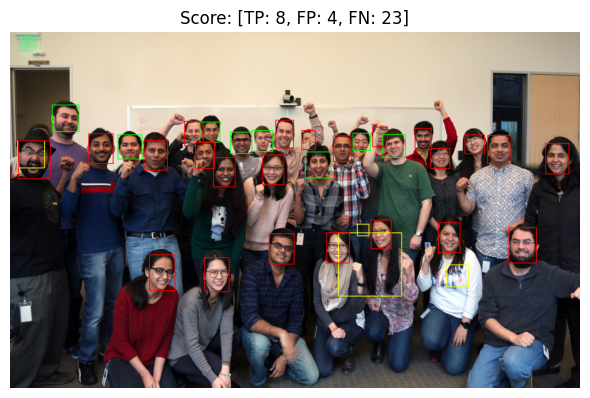

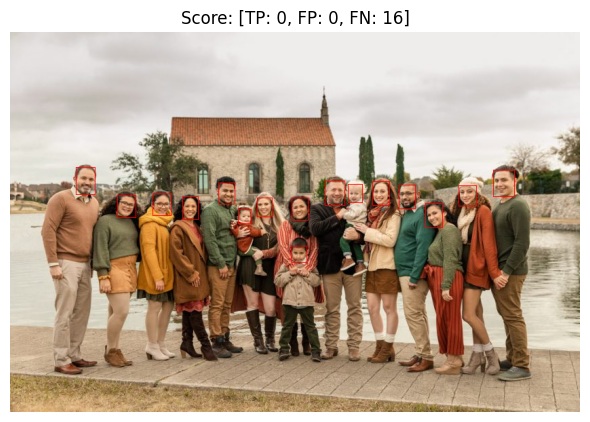

In [351]:
# Display the classified images
evaluation_results = evaluations_collection['brian_cascade.xml']
image_paths = get_image_paths(evaluation_results)
for path in image_paths:
    display_single_image(evaluation_results[path])